### Nicosia Air Quality Analysis

In [1]:
# importing the needed libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


### Importing  Nicosia Data

In [2]:

# import the three months of data for Payerene
Nicosia_Jan_Feb_2024 = pd.read_csv("Cyprus, Nicosia, Jan_Feb 2024.csv")
Nicosia_Mar_April_2024= pd.read_csv("Cyprus ,Nicosia, Mar_April 2024.csv")
Nicosia_May_June_2024= pd.read_csv("Cyprus,Nicosia,May_June 2024.csv")

# concatenate the data
Nicosia_Jan_June_2024= pd.concat([Nicosia_Jan_Feb_2024,Nicosia_Mar_April_2024,Nicosia_May_June_2024], axis=0)
#print(Nicosia_Jan_June_2024)
Nicosia_Jan_June_2024.head()

,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T01:00:00+00:00,2024-01-01T03:00:00+02:00,Asia/Nicosia,35.038056,33.057778,NaN,NaN,NaN,Unknown Governmental Organization,Republic of Cyprus Department of Labor Inspection
1,663497,Nicosia,o3,88.0,µg/m³,2024-01-01T02:00:00+00:00,2024-01-01T04:00:00+02:00,Asia/Nicosia,35.038056,33.057778,NaN,NaN,NaN,Unknown Governmental Organization,Republic of Cyprus Department of Labor Inspection
2,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T03:00:00+00:00,2024-01-01T05:00:00+02:00,Asia/Nicosia,35.038056,33.057778,NaN,NaN,NaN,Unknown Governmental Organization,Republic of Cyprus Department of Labor Inspection
3,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T04:00:00+00:00,2024-01-01T06:00:00+02:00,Asia/Nicosia,35.038056,33.057778,NaN,NaN,NaN,Unknown Governmental Organization,Republic of Cyprus Department of Labor Inspection
4,663497,Nicosia,o3,88.0,µg/m³,2024-01-01T05:00:00+00:00,2024-01-01T07:00:00+02:00,Asia/Nicosia,35.038056,33.057778,NaN,NaN,NaN,Unknown Governmental Organization,Republic of Cyprus Department of Labor Inspection


####  Data Cleaning
This process will involve the following steps:

•Dropping unneccesary columns.

•Handling missing values.

•Removing duplicates.

•Concerting datetimeLocal and datetimeUtc to a pandas datetime

•Setting datetimeLocal and datetimeUtc as index

•Creating a pivot table for the with the pollutants as the column and thedatetimeUtc as index

In [3]:
# drop the unnecessary columns
"""
Cell generated by Data Wrangler.
"""
def clean_data(Nicosia_Jan_June_2024):
    # Drop column: 'country_iso'
    Nicosia_Jan_June_2024= Nicosia_Jan_June_2024.drop(columns=['country_iso'])
    # Drop column: 'isMobile'
    Nicosia_Jan_June_2024= Nicosia_Jan_June_2024.drop(columns=['isMobile'])
    # Drop column: 'isMonitor'
    Nicosia_Jan_June_2024= Nicosia_Jan_June_2024.drop(columns=['isMonitor'])
    # Drop column: 'owner_name's
    Nicosia_Jan_June_2024= Nicosia_Jan_June_2024.drop(columns=['owner_name'])
    # Drop column: 'provider'
    Nicosia_Jan_June_2024= Nicosia_Jan_June_2024.drop(columns=['provider'])
    return Nicosia_Jan_June_2024
Nicosia_Jan_June_2024= clean_data(Nicosia_Jan_June_2024).copy()
Nicosia_Jan_June_2024.head()

,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude
0,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T01:00:00+00:00,2024-01-01T03:00:00+02:00,Asia/Nicosia,35.038056,33.057778
1,663497,Nicosia,o3,88.0,µg/m³,2024-01-01T02:00:00+00:00,2024-01-01T04:00:00+02:00,Asia/Nicosia,35.038056,33.057778
2,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T03:00:00+00:00,2024-01-01T05:00:00+02:00,Asia/Nicosia,35.038056,33.057778
3,663497,Nicosia,o3,87.0,µg/m³,2024-01-01T04:00:00+00:00,2024-01-01T06:00:00+02:00,Asia/Nicosia,35.038056,33.057778
4,663497,Nicosia,o3,88.0,µg/m³,2024-01-01T05:00:00+00:00,2024-01-01T07:00:00+02:00,Asia/Nicosia,35.038056,33.057778


In [4]:
# checking for duplicate values
dup = Nicosia_Jan_June_2024.duplicated().sum()
print(f'The number of duplicated values is: {dup}')

# converting datetime for Utc and Local to datetime format
Nicosia_Jan_June_2024['datetimeUtc'] = pd.to_datetime(Nicosia_Jan_June_2024['datetimeUtc'])
Nicosia_Jan_June_2024['datetimeLocal'] = pd.to_datetime(Nicosia_Jan_June_2024['datetimeLocal'])

The number of duplicated values is: 0


In [5]:
# creating a pivot table
Nicosia_Jan_June_2024_table = Nicosia_Jan_June_2024.pivot_table(
    values='value',
    index=['datetimeLocal', 'datetimeUtc'],
    columns='parameter'
)
# resetting the index for readability
Nicosia_Jan_June_2024_table.reset_index(inplace=True)

# filling the missing value with 0
Nicosia_Jan_June_2024_table = Nicosia_Jan_June_2024_table.fillna(0)


### Descriptive Statistics

In [6]:
# describing the Nicosia_Jan_June_2024_table
desc = [Nicosia_Jan_June_2024_table['co'].describe(),Nicosia_Jan_June_2024_table['o3'].describe(),Nicosia_Jan_June_2024_table['pm10'].describe(),Nicosia_Jan_June_2024_table['pm25'].describe()]
desc = pd.DataFrame(desc)
print("The descriptive statistics for the pollutants is:", '\n', desc)

The descriptive statistics for the pollutants is: 
        count        mean        std   min      25%    50%    75%    max
co    3262.0  173.876174  86.619673 -90.0  140.000  180.0  220.0  830.0
o3    3262.0   88.751380  32.196705  -1.0   80.000   94.0  110.0  160.0
pm10  3262.0   21.015600  38.074739   0.0    7.300   14.0   25.0  970.0
pm25  3262.0    9.473478   9.517745   0.0    4.225    7.9   13.0  210.0


### Compare the levels of polutants in Nicosia

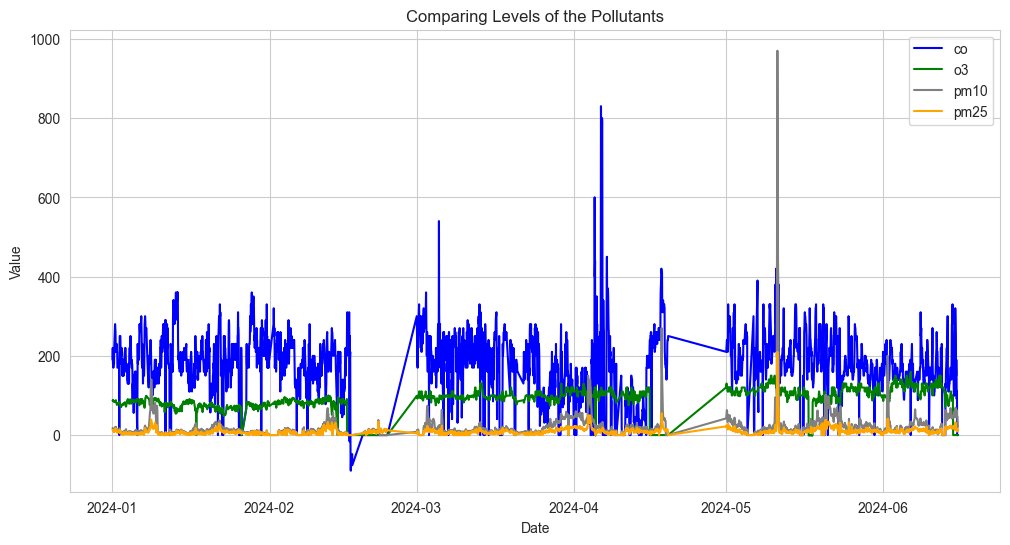

In [7]:
# set style to white grid
from cProfile import label


sns.set_style('whitegrid')

# setting the figure size
plt.figure(figsize=(12,6))
sns.lineplot(data =Nicosia_Jan_June_2024_table, x='datetimeUtc', y='co', label='co', color='blue')
sns.lineplot(data =Nicosia_Jan_June_2024_table, x='datetimeUtc', y='o3', label='o3', color='green')
sns.lineplot(data =Nicosia_Jan_June_2024_table, x='datetimeUtc', y='pm10', label='pm10', color='grey')
sns.lineplot(data =Nicosia_Jan_June_2024_table, x='datetimeUtc', y='pm25', label='pm25', color='orange')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparing Levels of the Pollutants')
plt.legend()
plt.show()

#The CO levels (blue line) show high variability with significant spikes, especially in late March and early April, reaching up to 800.

O3 levels (green line) are relatively stable, typically ranging between 0 and 200, with occasional spikes around late April.

PM10 (gray line) and PM2.5 (orange line) remain low and stable throughout the period, rarely exceeding 100.

## Calculating The Air Quality Index For Each Parameter and the Total AQI
The AQI is calculated based on air pollutant concentrations over a specific averaging period (usually 24 hours). These concentrations are obtained from air monitors or models. The Air Quality Index (AQI) provides a numerical value that reflects the concentration of air pollutants in the ambient air. These pollutants include things like particulate matter (PM2.5 and PM10), ozone (O3), and carbon monoxide (CO).

In [8]:
# create a breakpoint dictionary
breakpoints = {
    'o3': [(0.000, 0.054, 0, 50), (0.055, 0.070, 51, 100), (0.071, 0.085, 101, 150), (0.086, 0.105, 151, 200), (0.106, 0.200, 201, 300)],
    'co': [(0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200), (15.5, 30.4, 201, 300)],
    'pm25': [(0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300)],
    'pm10': [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150), (255, 354, 151, 200), (355, 424, 201, 300)]
}
# declare a function calculate_aqi
def calculate_aqi(concentration, breakpoints):
    for bp in breakpoints:
        if bp[0] <= concentration <= bp[1]:
            return (bp[3] - bp[2]) / (bp[1] - bp[0]) * (concentration - bp[0]) + bp[2]
    return None
# Sample DataFrame with pollutant concentrations
data = {
    'datetimeUtc': pd.date_range(start='2024-01-01', periods=4369, freq='H'),
    'o3': np.random.uniform(0, 0.2, 4369),
    'co': np.random.uniform(0, 15, 4369),
    'pm25': np.random.uniform(0, 250, 4369),
    'pm10': np.random.uniform(0, 430, 4369)
}
nicosia_Aqi = pd.DataFrame(data)

# Calculate AQI for each pollutant
nicosia_Aqi['AQI_o3'] = nicosia_Aqi['o3'].apply(lambda x: calculate_aqi(x, breakpoints['o3']))
nicosia_Aqi['AQI_co'] = nicosia_Aqi['co'].apply(lambda x: calculate_aqi(x, breakpoints['co']))
nicosia_Aqi['AQI_pm25'] = nicosia_Aqi['pm25'].apply(lambda x: calculate_aqi(x, breakpoints['pm25']))
nicosia_Aqi['AQI_pm10'] = nicosia_Aqi['pm10'].apply(lambda x: calculate_aqi(x, breakpoints['pm10']))

# Calculate overall AQI as the maximum of individual AQIs
nicosia_Aqi['AQI'] = nicosia_Aqi[['AQI_o3', 'AQI_co', 'AQI_pm25', 'AQI_pm10']].max(axis=1)
nicosia_Aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetimeUtc  4369 non-null   datetime64[ns]
 1   o3           4369 non-null   float64       
 2   co           4369 non-null   float64       
 3   pm25         4369 non-null   float64       
 4   pm10         4369 non-null   float64       
 5   AQI_o3       4278 non-null   float64       
 6   AQI_co       4290 non-null   float64       
 7   AQI_pm25     4364 non-null   float64       
 8   AQI_pm10     4276 non-null   float64       
 9   AQI          4369 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 341.5 KB


### Filling missing values:

In [9]:
aqi_columns = ['AQI_o3', 'AQI_co', 'AQI_pm25', 'AQI_pm10']
# Applying forward fill (ffill) to each AQI column
for column in aqi_columns:
    nicosia_Aqi[column].fillna(method='ffill', inplace=True) 
nicosia_Aqi.head()

,datetimeUtc,o3,co,pm25,pm10,AQI_o3,AQI_co,AQI_pm25,AQI_pm10,AQI
0,2024-01-01 00:00:00,0.091113,7.558220,70.556484,185.466561,164.187401,81.582200,158.774159,116.079409,164.187401
1,2024-01-01 01:00:00,0.075165,2.379732,6.532378,279.586156,115.577041,27.042409,27.218241,163.168905,163.168905
2,2024-01-01 02:00:00,0.045110,13.184739,211.207797,281.595168,41.768188,162.569730,261.160879,164.163265,261.160879
3,2024-01-01 03:00:00,0.115660,0.791504,125.106364,357.670835,211.173385,8.994363,186.940061,204.832067,211.173385
4,2024-01-01 04:00:00,0.094637,5.917768,228.480800,155.448954,173.275207,65.177678,278.278271,101.222209,278.278271


### Exploratory Data analysis
•Here, we will compare the level of AQI for each pollutant in for each hour.

•We will then resample the data to a daily and monthly basis to using mean as an aggregate function.

•We will also analyse the trends of the total AQI in the six months.

•We will compare the level of pollutants using a piechart

•We will analyse the relationship between each pollutant using a correlation heatmap.

•We will compare the hourly trends of the total AQI and also do the same with a resampled data

•Finally, we will detect seasonality using Additive decomposition.
<!--  -->
•Tools to be used include a lineplot, timeplot, correlation heatmap

## Comparing the AQI level of pollutants hourly

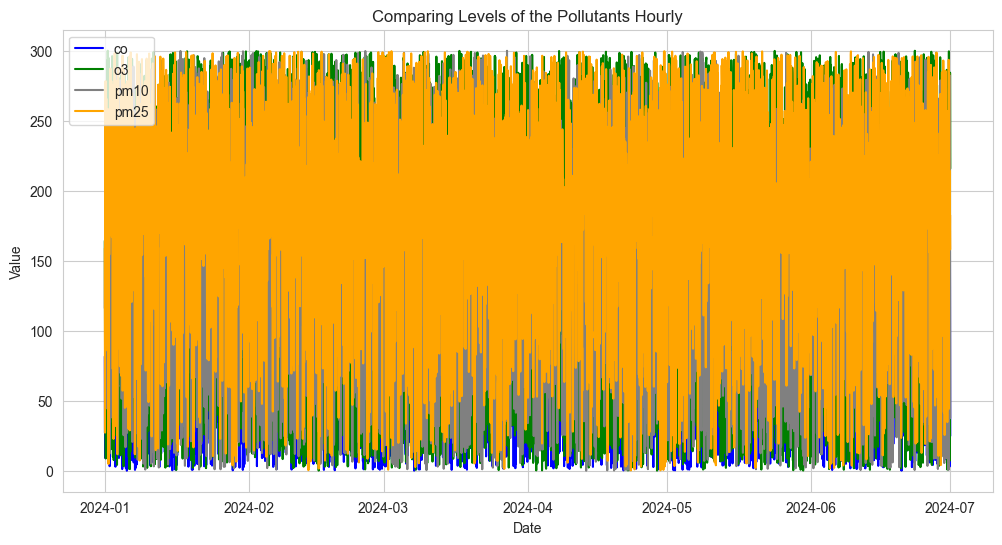

In [10]:

plt.figure(figsize=(12,6))
sns.lineplot(data = nicosia_Aqi, x='datetimeUtc', y='AQI_co', label='co', color='blue')
sns.lineplot(data = nicosia_Aqi, x='datetimeUtc', y='AQI_o3', label='o3', color='green')
sns.lineplot(data = nicosia_Aqi, x='datetimeUtc', y='AQI_pm10', label='pm10', color='grey')
sns.lineplot(data = nicosia_Aqi, x='datetimeUtc', y='AQI_pm25', label='pm25', color='orange')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparing Levels of the Pollutants Hourly')
plt.legend()
plt.grid(True)
plt.show()

### Comparing the AQI level of pollutants resampled daily

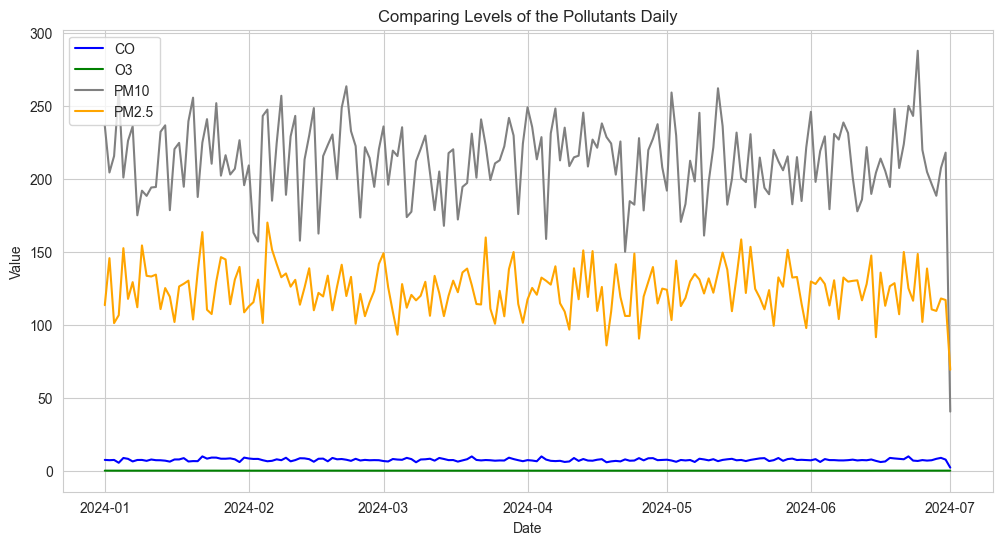

In [11]:

# Resampling the data to a daily basis for a clearer view
nicosia_Aqi_resampled_daily = nicosia_Aqi.resample('D', on='datetimeUtc').mean()

# Setting the figure size
plt.figure(figsize=(12, 6))

# Creating line plots for each pollutant
sns.lineplot(data=nicosia_Aqi_resampled_daily, x='datetimeUtc', y='co', label='CO', color='blue')
sns.lineplot(data=nicosia_Aqi_resampled_daily, x='datetimeUtc', y='o3', label='O3', color='green')
sns.lineplot(data=nicosia_Aqi_resampled_daily, x='datetimeUtc', y='pm10', label='PM10', color='grey')
sns.lineplot(data=nicosia_Aqi_resampled_daily, x='datetimeUtc', y='pm25', label='PM2.5', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparing Levels of the Pollutants Daily')
plt.legend()
plt.show()


The graph displays daily levels of four pollutants (CO, O3, PM10, and PM2.5) from January 2024 to July 2024. Here are three key observations:

1. **PM10 and PM2.5 Levels**:
   - PM10 (gray line) and PM2.5 (orange line) show the highest and most variable levels among the pollutants.
   - PM10 values generally range between 200 and 300, with noticeable fluctuations throughout the period.
   - PM2.5 values mostly range between 100 and 150, with consistent variability, indicating significant presence in the air.

2. **Ozone (O3) Levels**:
   - O3 levels (green line) are relatively stable and consistently lower than PM10 and PM2.5, typically ranging between 100 and 150.

3. **Carbon Monoxide (CO) Levels**:
   - CO levels (blue line) remain very low and stable throughout the period, rarely exceeding 50, indicating minimal fluctuations and presence compared to other pollutants.

### Comparing AQI levels of pollutants resampled monthly

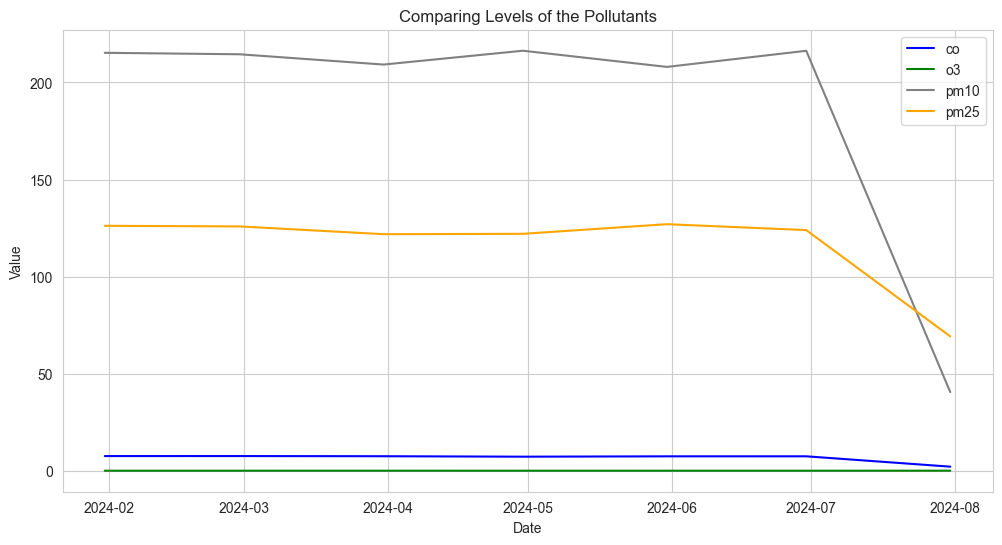

In [12]:


# resample to monthly frequency using the mean as an aggredation
nicosia_Aqi_resampled_mounthly = nicosia_Aqi.resample('M', on='datetimeUtc').mean()

# plotting the lineplot with the resamples data
# setting the figure size
plt.figure(figsize=(12,6))
sns.lineplot(data = nicosia_Aqi_resampled_mounthly, x='datetimeUtc', y='co', label='co', color='blue')
sns.lineplot(data = nicosia_Aqi_resampled_mounthly, x='datetimeUtc', y='o3', label='o3', color='green')
sns.lineplot(data = nicosia_Aqi_resampled_mounthly, x='datetimeUtc', y='pm10', label='pm10', color='grey')
sns.lineplot(data = nicosia_Aqi_resampled_mounthly, x='datetimeUtc', y='pm25', label='pm25', color='orange')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparing Levels of the Pollutants')
plt.legend()
plt.show()

#pm10 ,pm25are consistently high, indicate that sources of larger particulates are higher throughout the year  within this locale.

levels are higher compared to other pollutants, showing significant fluctuation over the period.

#Combustion from vehicles, industrial processes, residential heating, agricultural burning, and construction dust.

#co and o3 levels :Given that motor vehicles are a significant source of CO emissions and also In colder climates.

#Vehicle Emissions:  colder climates, heating systems can be a significant source of CO emissions could be practiced more

### Recomendation:
Promoting Clean Energy: Encouraging the use of renewable energy sources to reduce reliance on fossil fuels.

#Sustain  co and o3 Control  Efforts.

In [13]:
result = adfuller(nicosia_Aqi['AQI_o3'])
# print out hte results
print('ADF Statistics:', result[0])
print('p-value', result[1])
print('Critical Value:', result[4]) # type: ignore

ADF Statistics: -39.19509983200655
p-value 0.0
Critical Value: {'1%': -3.431848659843383, '5%': -2.8622022244312633, '10%': -2.5671225065003824}


#Since the p-value is less than the significance level of 0.05, we reject the null hypothesis, suggesting that the o3 level is likely to be stationary

### Correlation heatmap for the pollutants

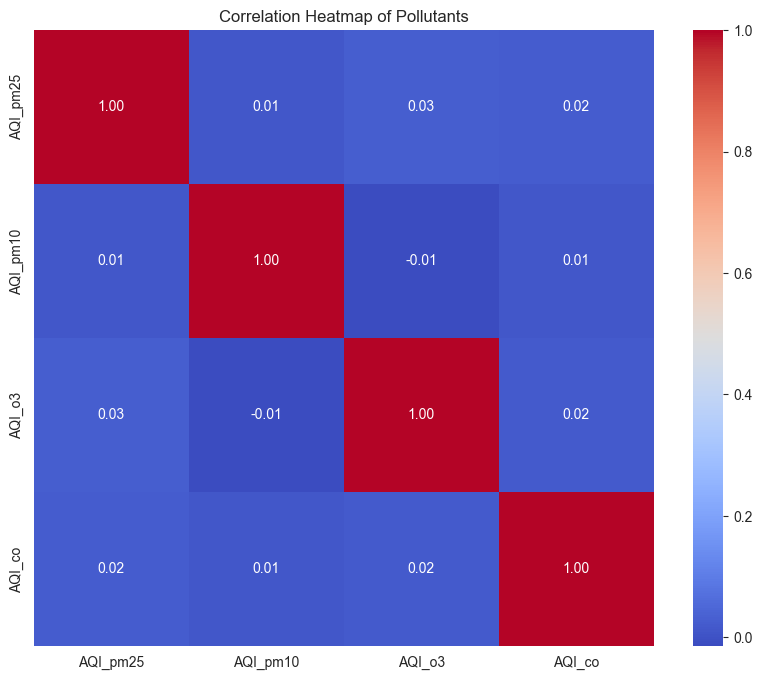

In [14]:
# correlation heatmap for the pollutants
# selecting the pollutants
pollutants = ['AQI_pm25', 'AQI_pm10', 'AQI_o3', 'AQI_co']

# calculating the correlation matrix
corr_matrix = nicosia_Aqi[pollutants].corr()
# plotting a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt = '.2f')
plt.title('Correlation Heatmap of Pollutants')
plt.show()


#AQI_co and AQI_o3: Correlation is -0.00, indicating no significant correlation.

#AQI_03 and AQI_pm10: Correlation is 0.02, indicating a very weak positive correlation.

### A Lineplot for the AQI trends

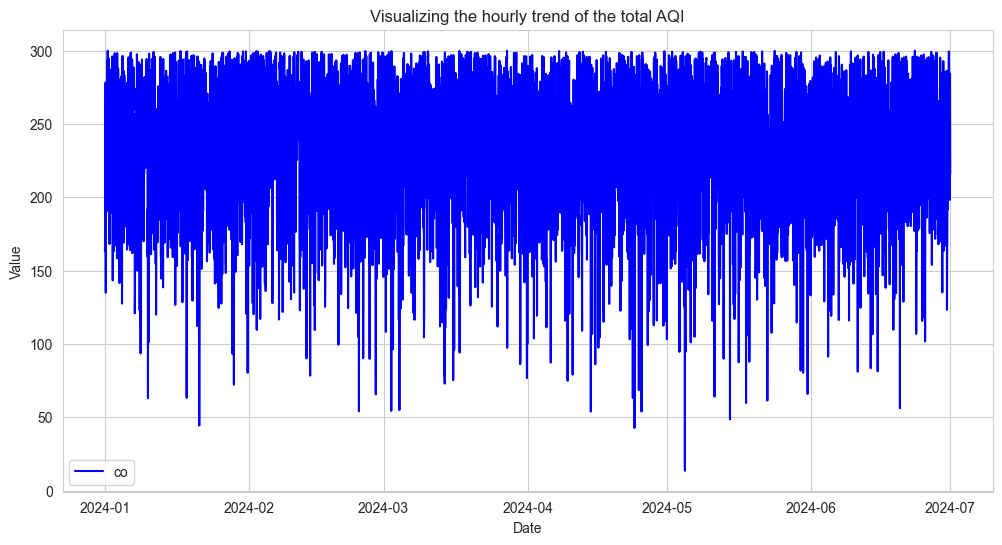

In [15]:

# setting the figure size
plt.figure(figsize=(12,6))
sns.lineplot(data = nicosia_Aqi, x='datetimeUtc', y='AQI', label='co', color='blue')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Visualizing the hourly trend of the total AQI')
plt.legend()
plt.grid(True)
plt.show()

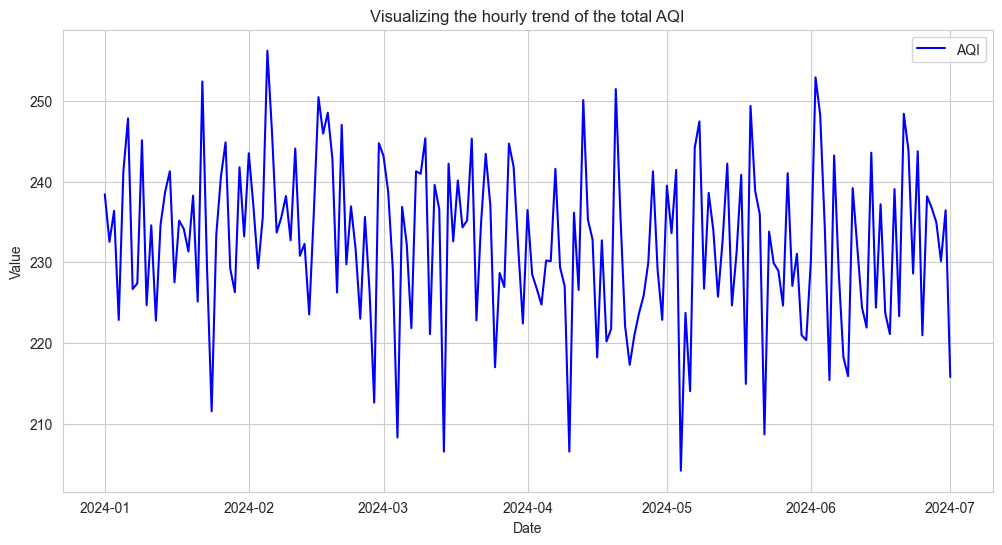

In [16]:
# setting the figure size
plt.figure(figsize=(12,6))
sns.lineplot(data = nicosia_Aqi_resampled_daily, x='datetimeUtc', y='AQI', label='AQI', color='blue')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Visualizing the hourly trend of the total AQI')
plt.legend()
plt.grid(True)
plt.show()

#The AQI levels fluctuate significantly over the observed period. 

#There are noticeable peaks and troughs, indicating periods of higher and lower concentration.

### Detecting Seasonality using Additive Decomposition

#Additive decomposition separates the time series into trend, seasonal, and residual components assuming that the time series is equal to trend + seasonality + noise

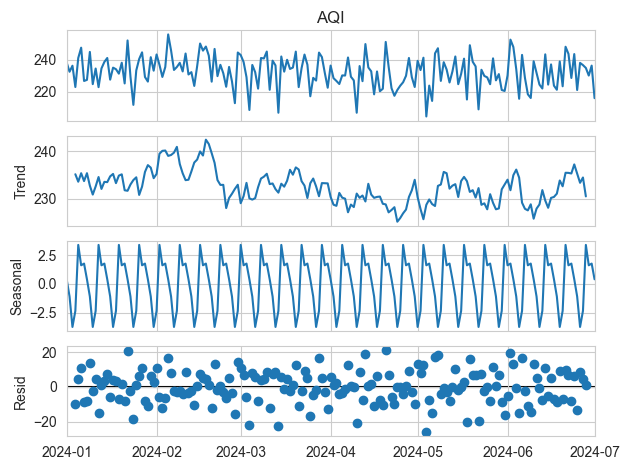

In [17]:
# checking for seasonality
result = seasonal_decompose(nicosia_Aqi_resampled_daily['AQI'], model='additive')
result.plot()
plt.show()

#Observed (AQI): The observed AQI data shows significant short-term fluctuations, indicating variability in air quality over time.

#Trend: The trend component reveals a general upward and downward pattern, indicating periods of improving and worsening air quality over the observed period.

#Seasonal: The seasonal component displays a consistent, repeating pattern, suggesting strong seasonal effects on AQI that recur regularly.

#Residuals (Resid): The residuals are scattered around zero with no clear pattern, indicating that the model has effectively captured the trend and seasonal components, leaving only random noise.

##### Seasonality: The clear periodic pattern in the seasonal component confirms that there is a strong seasonal effect in the AQI data, repeating regularly within the observed period.
##### This decomposition analysis confirms the presence of both a trend and seasonality in the AQI data. The strong seasonal component suggests regular fluctuations at consistent intervals, while the trend indicates the overall direction of the AQI over time

### Creating Subplots for the Daily AQI Levels

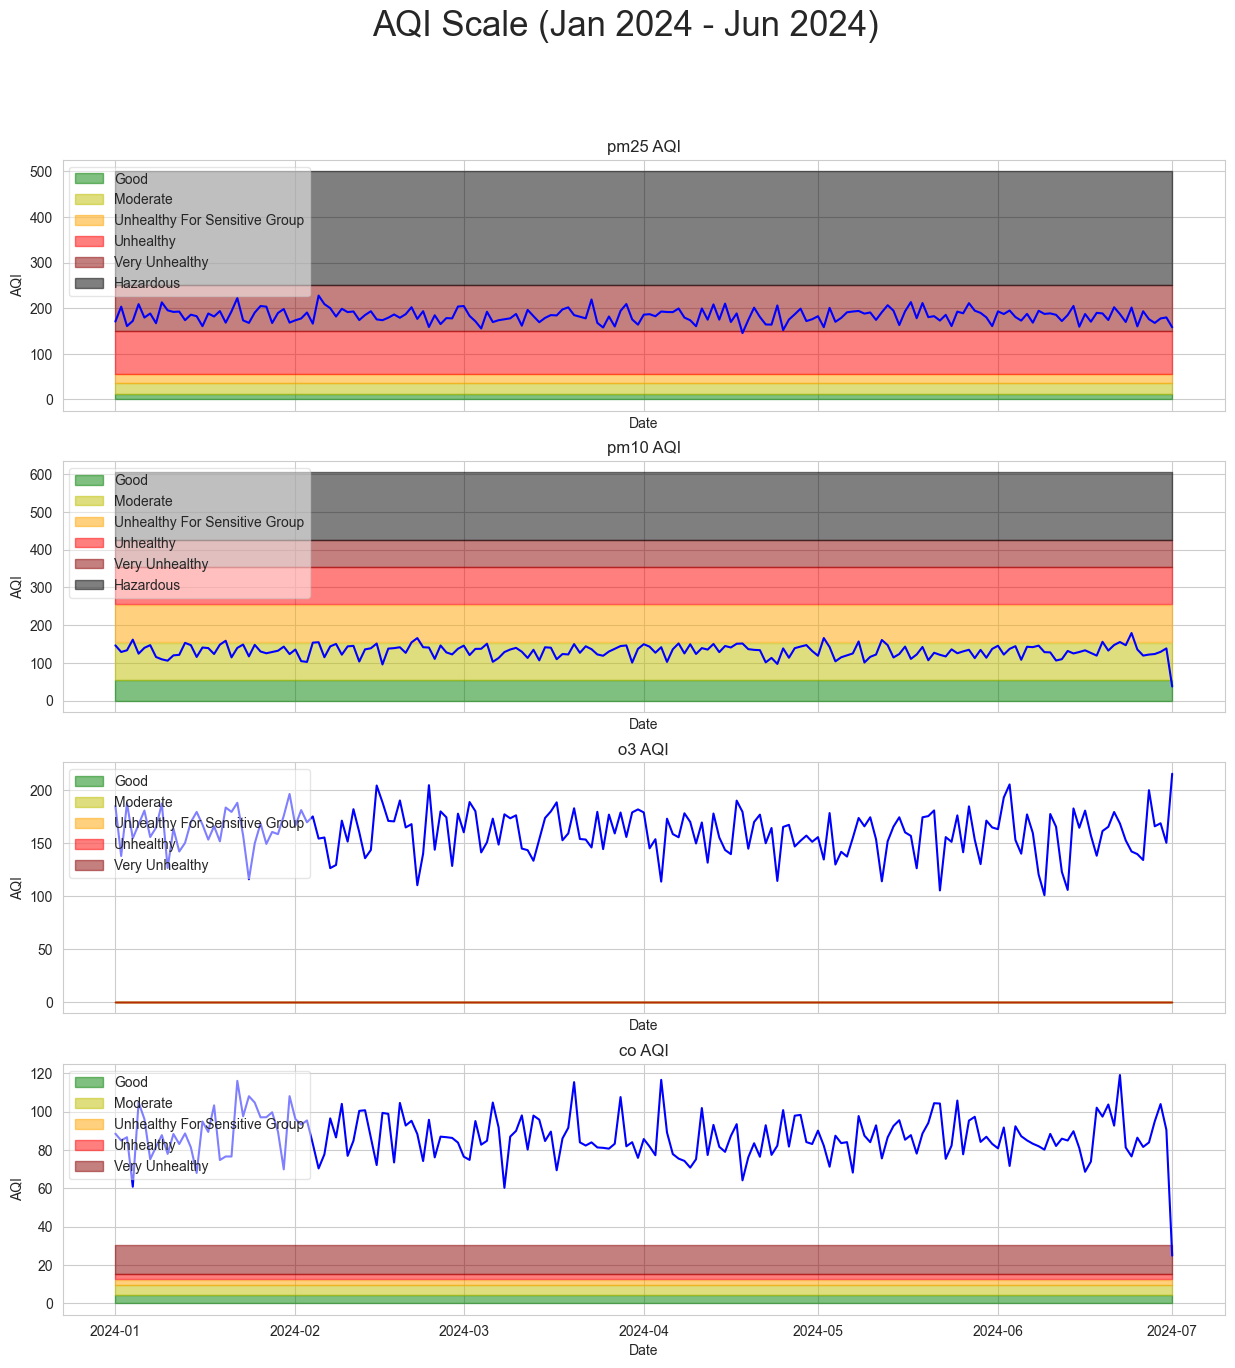

In [18]:
# create a breakpoint dictionary
breakpoints = {
    'pm25': [(0.0, 42.0, 0, 50), (42.1, 84.0, 51, 100), (84.1, 126.0, 101, 150), (126.1, 168.0, 151, 200), (168.1, 210.0, 201, 300)],
    'pm10': [(0.0, 54.0, 0, 50), (55.1, 154.0, 51, 100), (155.0, 254.0, 101, 150), (255.0, 354.0, 151, 200), (355.0, 424.0, 201, 300)],
    'o3': [(0.0, 26.67, 0, 50), (26.68, 53.33, 51, 100), (53.34, 80.0, 101, 150), (80.01, 106.67, 151, 200), (106.68, 133.33, 201, 300), (133.34, 160.0, 301, 500)],
    'co': [(0.0, 138.3, 0, 50), (138.4, 276.6, 51, 100), (276.7, 414.9, 101, 150), (415.0, 553.2, 151, 200), (553.3, 691.5, 201, 300), (691.6, 830.0, 301, 500)]
}

def index_scale(plotnumber, data, pollutant):
    if pollutant == 'pm25':
        scales = [(0, 12, 'Good', 'g'), (12.1, 35.4, 'Moderate', 'y'), (35.5, 55.4, 'Unhealthy For Sensitive Group', 'orange'),
                  (55.5, 150.4, 'Unhealthy', 'r'), (150.5, 250.4, 'Very Unhealthy', 'darkred'), (250.5, 500.4, 'Hazardous', 'black')]
    elif pollutant == 'pm10':
        scales = [(0, 54, 'Good', 'g'), (55, 154, 'Moderate', 'y'), (155, 254, 'Unhealthy For Sensitive Group', 'orange'),
                  (255, 354, 'Unhealthy', 'r'), (355, 424, 'Very Unhealthy', 'darkred'), (425, 604, 'Hazardous', 'black')]
    elif pollutant == 'o3':
        scales = [(0.000, 0.054, 'Good', 'g'), (0.055, 0.070, 'Moderate', 'y'), (0.071, 0.085, 'Unhealthy For Sensitive Group', 'orange'),
                  (0.086, 0.105, 'Unhealthy', 'r'), (0.106, 0.200, 'Very Unhealthy', 'darkred')]
    elif pollutant == 'co':
        scales = [(0.0, 4.4, 'Good', 'g'), (4.5, 9.4, 'Moderate', 'y'), (9.5, 12.4, 'Unhealthy For Sensitive Group', 'orange'),
                  (12.5, 15.4, 'Unhealthy', 'r'), (15.5, 30.4, 'Very Unhealthy', 'darkred')]
    
    for scale in scales:
        axs[plotnumber].fill_between(x=data.index, y1=scale[0], y2=scale[1], alpha=0.5, label=scale[2], color=scale[3])
    axs[plotnumber].set_title(f'{pollutant} AQI')
    axs[plotnumber].legend(loc='upper left', framealpha=0.5)
    axs[plotnumber].set_xlabel('Date')
    axs[plotnumber].set_ylabel('AQI')

# Create subplots to visualize the AQI data from January to June 2024
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 15))
fig.suptitle('AQI Scale (Jan 2024 - Jun 2024)', fontsize=25)
pollutants = ['pm25', 'pm10', 'o3', 'co']

for i, pollutant in enumerate(pollutants):
    axs[i].plot(nicosia_Aqi_resampled_daily[f'AQI_{pollutant}'], color='blue')
    index_scale(i, nicosia_Aqi_resampled_daily, pollutant)

plt.show()

### Interpretation of the AQI Trends
PM2.5 and PM10 AQI: Both PM2.5 and PM10 levels consistently fluctuate within the "Unhealthy for Sensitive Groups" to "Unhealthy" range, indicating poor air quality that could affect vulnerable populations.

O3 AQI: Ozone levels show more variability, frequently moving between the "Moderate" and "Unhealthy for Sensitive Groups" categories, reflecting periods of elevated ozone pollution.

CO AQI: Carbon monoxide levels are generally in the "Good" to "Moderate" range but exhibit occasional spikes that may temporarily elevate the risk for sensitive individuals.

### Comparing the Levels of the pollutant in Tuen Mun

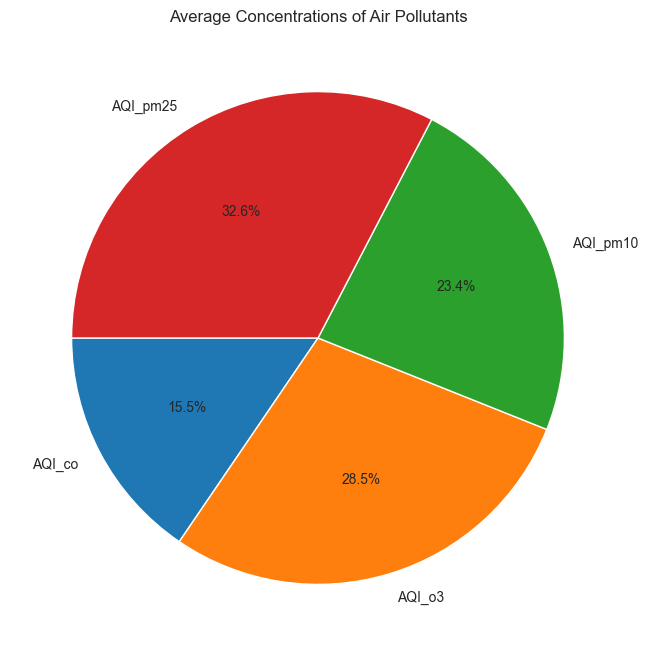

In [19]:
# Calculate average values
average_values =nicosia_Aqi[['AQI_co', 'AQI_o3', 'AQI_pm10', 'AQI_pm25']].mean()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(average_values, labels=average_values.index, autopct='%1.1f%%', startangle=180) # type: ignore
plt.title('Average Concentrations of Air Pollutants')
plt.show()
        

##The pie chart shows that PM10 (Particulate Matter 10 micrometers or less) and CO dominate the air quality data

The pie chart shows  that co and pm10 relatively  small comparing to the other polloutant.

constitutes a substantial portion of the pollutants, indicating the need for stringent air quality management.

